## Conditional Image Synthesis with Auxiliary Classifier GANs (2017)
- one of the Conditional GANs
- cGan -> sGan -> **acGan** -> infoGan

## Features
- The discriminator does two jobs.
    - job1 : Is this image real/fake? (Original Discriminator)
    - job2 : What is this image class? (Classifier)
- loss function
    - job1 loss : <br>$ L_{s} = E[logP(S = real | X_{real})] + E[logP(S=fake|X_{fake})]$
    - job2 loss : <br>$ L_{c} = E[logP(C = c | X_{real})] + E[logP(C=c|X_{fake})]$
- Discriminator maximizes $ L_{s} + L_{c} $
- Generator maximizes $ L_{c} - L_{s} $
- Others are same with my [DCGAN implementation](https://github.com/ZeroAct/GANs/blob/main/2_DCGAN/DCGAN.ipynb)


## Dataset
- Fashion MNist

## Import Modules

In [1]:
import sys
sys.path.insert(0, '../')

import os
import cv2
import tqdm
import random

import numpy as np

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import FashionMNIST

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

from utils import imshow, get_mean

random_seed = 123

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Download Fashion MNist
- We don't validate or test here.

In [2]:
os.makedirs('../dataset', exist_ok=True)

train_data = FashionMNIST('../dataset', train=True, download=True)
#test_data = FashionMNIST('../dataset', train=False, download=True)

In [3]:
classes = train_data.classes
train_images, train_labels = train_data.data, train_data.targets
#test_images, test_labels = test_data.data, test_data.targets

print(f"{len(train_images)} train images...")
#print(f"{len(test_images)} test images...")

60000 train images...


In [4]:
class_num = len(train_labels.unique())
print(f"class num : {class_num}")

class num : 10


<Figure size 864x288 with 0 Axes>

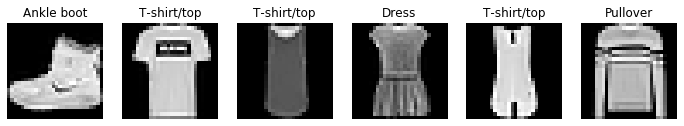

In [5]:
imshow(train_images[:6], train_labels[:6], classes)

## Build Network

### Generator

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # smaller than the paper architecture
        self.model = nn.Sequential(
            # (1 x 1) -> (4 x 4)
            nn.ConvTranspose2d(100 + class_num, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # (4 x 4) -> (7 x 7)
            nn.ConvTranspose2d(512, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # (7 x 7) -> (14 x 14)
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # (14 x 14) -> (28 x 28)
            nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z, y_vec):
        x = self.model(torch.cat((z, y_vec.view(-1, class_num, 1, 1)), dim=1))
        return x

### Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.head = nn.Sequential(
            # (28 x 28) -> (14 x 14)
            nn.Conv2d(1, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # (14 x 14) -> (7 x 7)
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # (7 x 7) -> (3 x 3)
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # real/fake net
        self.rfnet = nn.Sequential(
            # (3 x 3) -> (1 x 1)
            nn.Conv2d(512, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )
        
        # classifier
        self.classifier = nn.Sequential(
            # (3 x 3) -> (1 x 1)
            nn.Conv2d(512, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.head(x)
        
        rf = self.rfnet(x)
        cl = self.classifier(x)
        
        return rf.view(-1, 1), cl

In [8]:
G = Generator().to(device)
D = Discriminator().to(device)

### weight initialize

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    print(f"initialized {classname}")

In [10]:
G.apply(weights_init)
D.apply(weights_init)
print("success")

initialized ConvTranspose2d
initialized BatchNorm2d
initialized ReLU
initialized ConvTranspose2d
initialized BatchNorm2d
initialized ReLU
initialized ConvTranspose2d
initialized BatchNorm2d
initialized ReLU
initialized ConvTranspose2d
initialized Tanh
initialized Sequential
initialized Generator
initialized Conv2d
initialized BatchNorm2d
initialized LeakyReLU
initialized Conv2d
initialized BatchNorm2d
initialized LeakyReLU
initialized Conv2d
initialized BatchNorm2d
initialized LeakyReLU
initialized Sequential
initialized Conv2d
initialized Sigmoid
initialized Sequential
initialized Conv2d
initialized BatchNorm2d
initialized LeakyReLU
initialized Flatten
initialized Linear
initialized Sequential
initialized Discriminator
success


## Sampling function
- sampling latent z
- z.shape -> (batch_size, dim, 1, 1)

In [11]:
def sample_z(num=1, dim=100):
    return torch.randn(num, dim, 1, 1)

<Figure size 864x288 with 0 Axes>

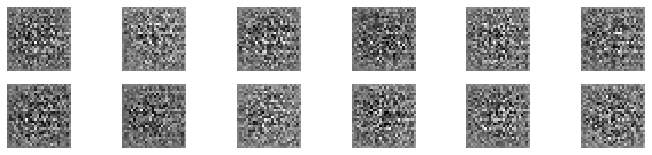

In [12]:
fake = G(sample_z(12, 100).to(device), torch.randn(12, 10).to(device))
imshow(fake.detach().cpu().reshape(-1, 28, 28))

## Hyperparameters

In [13]:
batch_size    = 32
learning_rate = 0.001
epochs        = 20

## Optimizer

In [14]:
optim_D = optim.Adam(D.parameters(), learning_rate)
optim_G = optim.Adam(G.parameters(), learning_rate)

## Loss Function

In [15]:
bce = F.binary_cross_entropy
ce = F.cross_entropy
ones = torch.ones(batch_size, 1).to(device)
zeros = torch.zeros(batch_size, 1).to(device)

def loss_fn_D(D, G, real, fake, target):
    rf_r, yhat_r = D(real)
    rf_f, yhat_f = D(fake)
    Ls = bce(rf_r, ones) + bce(rf_f, zeros)
    Lc = ce(yhat_r, target) + ce(yhat_f, target)
    return Ls + Lc

def loss_fn_G(D, G, fake, target):
    rf_f, yhat_f = D(fake)
    Ls = bce(rf_f, ones)
    Lc = ce(yhat_f, target)
    return Ls + Lc

## Build CustomDataset and Dataloader

In [16]:
class CustomDataset(Dataset):
    def __init__(self):
        super(CustomDataset).__init__()
        
        self.xs = train_images * (2 / 255) - 1.
        print(f"normalized [{self.xs.min()}, {self.xs.max()}]")
        
        self.ys_ = train_labels
        self.ys = torch.zeros(len(self.ys_), class_num)
        for i, y in enumerate(self.ys_):
            self.ys[i, y] = 1
        print(self.ys.dtype)
    
    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x.view(1, 28, 28), y

In [17]:
dataloader_params = {'batch_size': batch_size,
                     'shuffle': True,
                     'drop_last': True,
                     'num_workers': 0}

train_ds = CustomDataset()
train_gen = DataLoader(train_ds, **dataloader_params)

normalized [-1.0, 1.0]
torch.float32


## Training

Epoch 0/20 G_loss : 9.644872 D_loss : 2.078485: 100%|██████████████████████████████| 1875/1875 [01:02<00:00, 30.06it/s]


<Figure size 864x288 with 0 Axes>

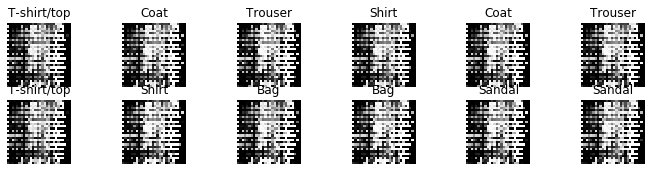

Epoch 1/20 G_loss : 9.036445 D_loss : 0.938967: 100%|██████████████████████████████| 1875/1875 [01:02<00:00, 29.92it/s]


<Figure size 864x288 with 0 Axes>

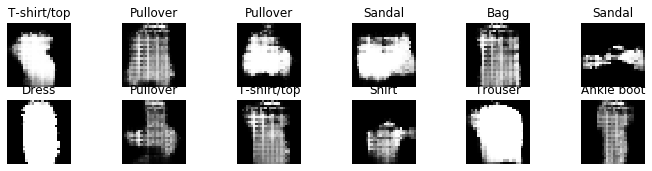

Epoch 2/20 G_loss : 6.385132 D_loss : 0.863440: 100%|██████████████████████████████| 1875/1875 [01:02<00:00, 29.97it/s]


<Figure size 864x288 with 0 Axes>

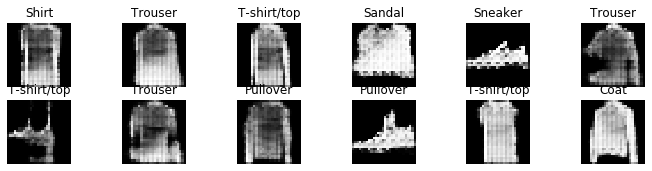

Epoch 3/20 G_loss : 5.483275 D_loss : 0.845796: 100%|██████████████████████████████| 1875/1875 [01:02<00:00, 29.98it/s]


<Figure size 864x288 with 0 Axes>

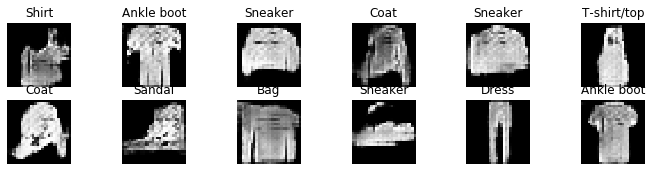

Epoch 4/20 G_loss : 4.747412 D_loss : 0.841254: 100%|██████████████████████████████| 1875/1875 [01:03<00:00, 29.35it/s]


<Figure size 864x288 with 0 Axes>

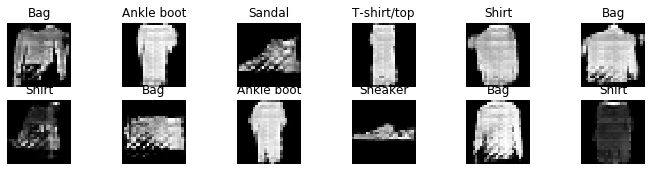

Epoch 5/20 G_loss : 4.534142 D_loss : 0.789901: 100%|██████████████████████████████| 1875/1875 [01:02<00:00, 29.87it/s]


<Figure size 864x288 with 0 Axes>

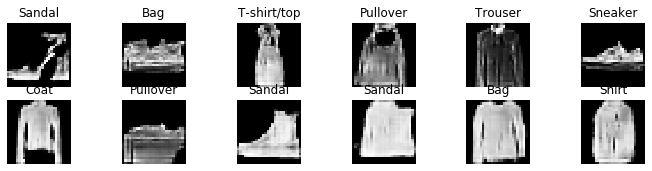

Epoch 6/20 G_loss : 4.128990 D_loss : 0.766372: 100%|██████████████████████████████| 1875/1875 [01:02<00:00, 29.95it/s]


<Figure size 864x288 with 0 Axes>

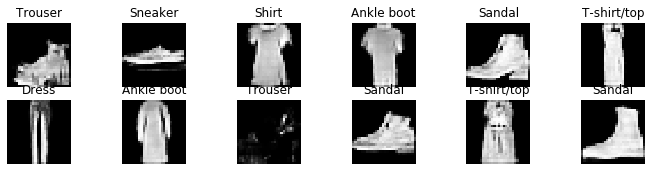

Epoch 7/20 G_loss : 3.912279 D_loss : 0.757510: 100%|██████████████████████████████| 1875/1875 [01:08<00:00, 27.35it/s]


<Figure size 864x288 with 0 Axes>

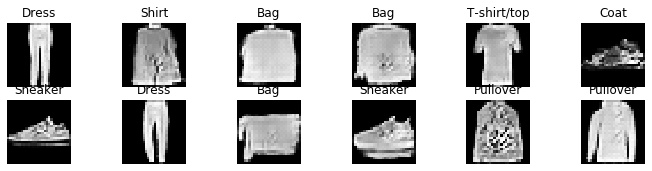

Epoch 8/20 G_loss : 3.852289 D_loss : 0.727346: 100%|██████████████████████████████| 1875/1875 [01:02<00:00, 29.95it/s]


<Figure size 864x288 with 0 Axes>

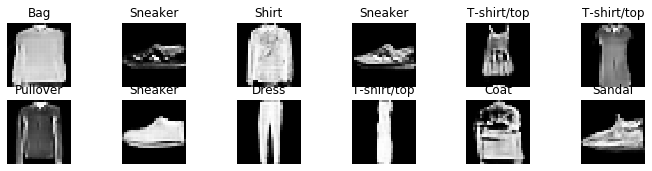

Epoch 9/20 G_loss : 3.813737 D_loss : 0.719501: 100%|██████████████████████████████| 1875/1875 [01:02<00:00, 29.93it/s]


<Figure size 864x288 with 0 Axes>

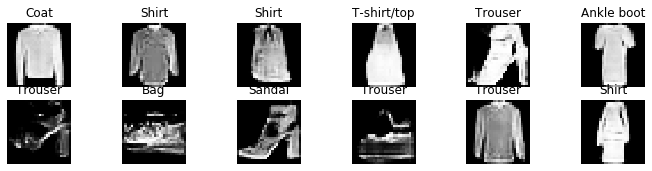

Epoch 10/20 G_loss : 3.689085 D_loss : 0.704327: 100%|█████████████████████████████| 1875/1875 [01:02<00:00, 29.97it/s]


<Figure size 864x288 with 0 Axes>

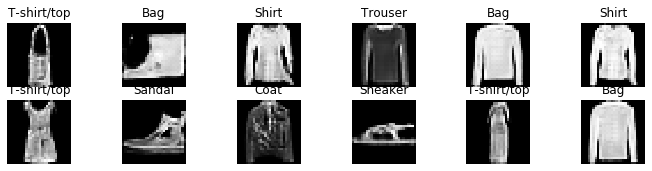

Epoch 11/20 G_loss : 3.679397 D_loss : 0.670013: 100%|█████████████████████████████| 1875/1875 [01:03<00:00, 29.35it/s]


<Figure size 864x288 with 0 Axes>

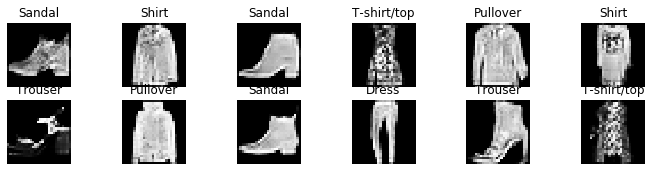

Epoch 12/20 G_loss : 3.752839 D_loss : 0.650588: 100%|█████████████████████████████| 1875/1875 [01:03<00:00, 29.34it/s]


<Figure size 864x288 with 0 Axes>

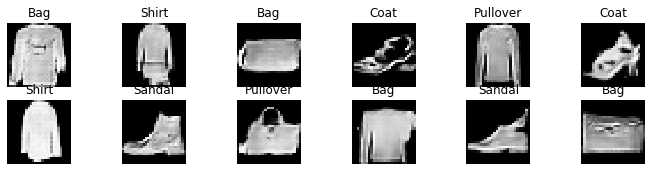

Epoch 13/20 G_loss : 3.708891 D_loss : 0.639732: 100%|█████████████████████████████| 1875/1875 [01:03<00:00, 29.43it/s]


<Figure size 864x288 with 0 Axes>

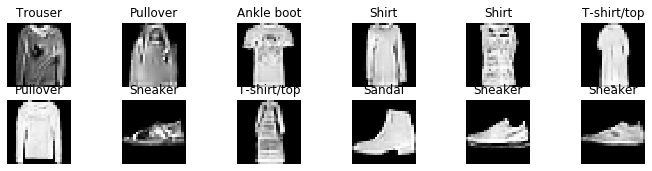

Epoch 14/20 G_loss : 3.757976 D_loss : 0.608040: 100%|█████████████████████████████| 1875/1875 [01:03<00:00, 29.44it/s]


<Figure size 864x288 with 0 Axes>

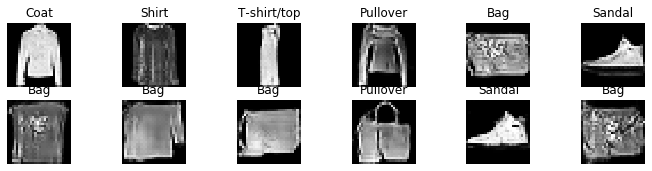

Epoch 15/20 G_loss : 3.794590 D_loss : 0.593867: 100%|█████████████████████████████| 1875/1875 [01:02<00:00, 29.90it/s]


<Figure size 864x288 with 0 Axes>

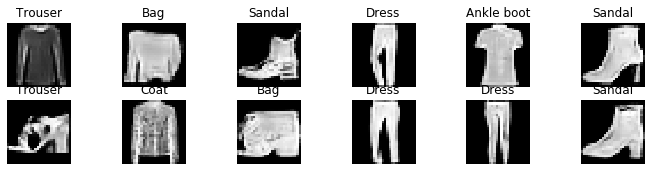

Epoch 16/20 G_loss : 3.780605 D_loss : 0.585943: 100%|█████████████████████████████| 1875/1875 [01:03<00:00, 29.35it/s]


<Figure size 864x288 with 0 Axes>

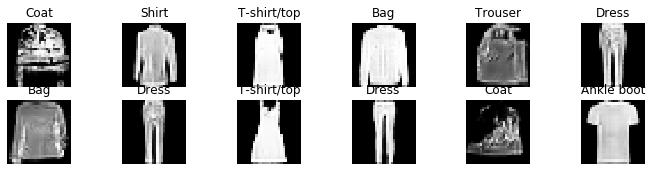

Epoch 17/20 G_loss : 3.880545 D_loss : 0.561660: 100%|█████████████████████████████| 1875/1875 [01:03<00:00, 29.55it/s]


<Figure size 864x288 with 0 Axes>

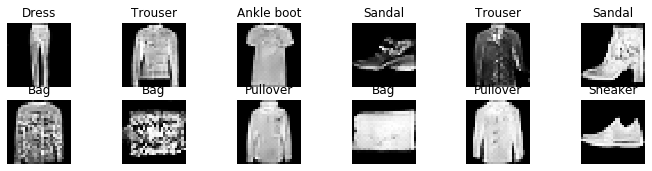

Epoch 18/20 G_loss : 3.956152 D_loss : 0.530053: 100%|█████████████████████████████| 1875/1875 [01:02<00:00, 29.79it/s]


<Figure size 864x288 with 0 Axes>

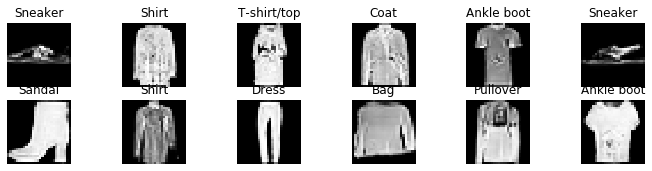

Epoch 19/20 G_loss : 4.060179 D_loss : 0.518796: 100%|█████████████████████████████| 1875/1875 [01:03<00:00, 29.68it/s]


<Figure size 864x288 with 0 Axes>

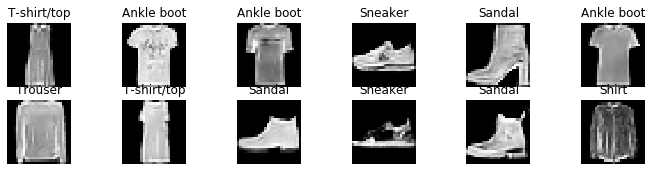

In [18]:
for epoch in range(epochs):
    d_losses = []
    g_losses = []
    
    D.train()
    G.train()
    
    pgbar = tqdm.tqdm(train_gen, total=len(train_gen))
    for real, y_vec in pgbar:
        
        real   = real.to(device)
        y_vec  = y_vec.to(device)
        target = torch.max(y_vec, axis=-1)[1]
        
        # train Discriminator
        z     = sample_z(batch_size).to(device)
        
        fake = G(z, y_vec)
        
        optim_D.zero_grad()
        d_loss = loss_fn_D(D, G, real, fake, target)
        d_loss.backward()
        optim_D.step()
    
        # train Generator
        z    = sample_z(batch_size).to(device)
        
        fake = G(z, y_vec)
        
        optim_G.zero_grad()
        g_loss = loss_fn_G(D, G, fake, target)
        g_loss.backward()
        optim_G.step()
        
        # print
        d_losses.append(d_loss.detach().cpu().numpy())
        g_losses.append(g_loss.detach().cpu().numpy())
        
        pgbar.set_description(f"Epoch {epoch}/{epochs} G_loss : {get_mean(g_losses):.6f} D_loss : {get_mean(d_losses):.6f}")

    # visualize
    D.eval()
    G.eval()
    
    show_num = 12
    
    class_names = []
    target_vecs = torch.zeros(show_num, class_num).to(device)
    for i in range(show_num):
        cls_num = random.randint(0, class_num-1)
        target_vecs[i, cls_num] = 1
        class_names.append(classes[cls_num])
    
    z = sample_z(show_num).to(device)
    fake = G(z, target_vecs)
    
    imshow(fake.detach().cpu().numpy().reshape(-1, 28, 28), class_names)

## Target Generating

In [34]:
def target_generate(idx, show_num=6):
    class_names = []
    target_vecs = torch.zeros(show_num, class_num).to(device)
    for i in range(show_num):
        target_vecs[i, idx] = 1
        class_names.append(classes[idx])

    z = sample_z(show_num).to(device)
    fake = G(z, target_vecs)

    imshow(fake.detach().cpu().numpy().reshape(-1, 28, 28), class_names)

<Figure size 864x288 with 0 Axes>

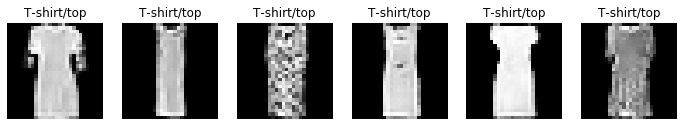

In [35]:
target_generate(0)

<Figure size 864x288 with 0 Axes>

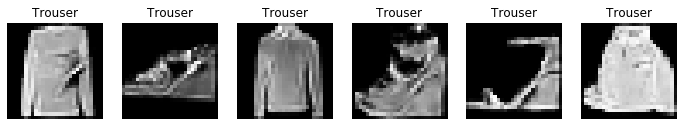

In [36]:
target_generate(1)

<Figure size 864x288 with 0 Axes>

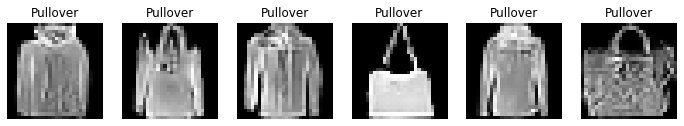

In [37]:
target_generate(2)

<Figure size 864x288 with 0 Axes>

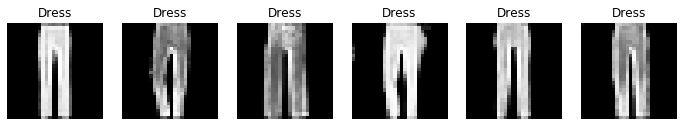

In [38]:
target_generate(3)

<Figure size 864x288 with 0 Axes>

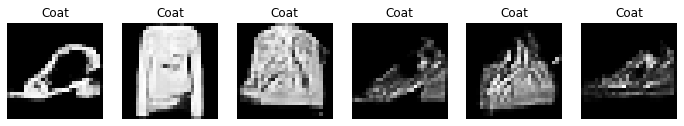

In [39]:
target_generate(4)

<Figure size 864x288 with 0 Axes>

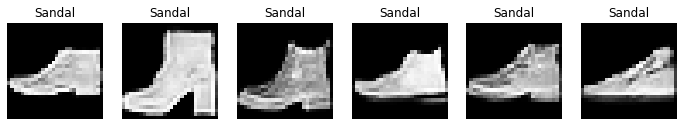

In [40]:
target_generate(5)

<Figure size 864x288 with 0 Axes>

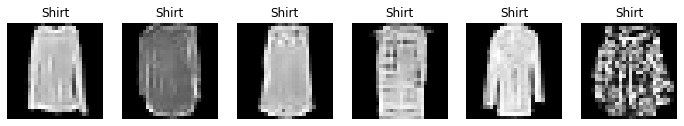

In [41]:
target_generate(6)

<Figure size 864x288 with 0 Axes>

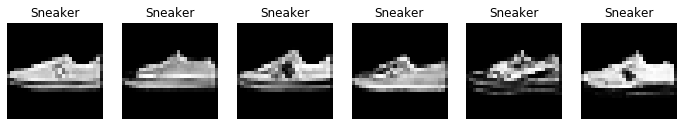

In [42]:
target_generate(7)

<Figure size 864x288 with 0 Axes>

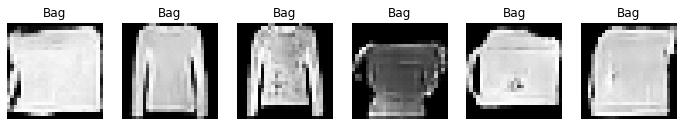

In [43]:
target_generate(8)

<Figure size 864x288 with 0 Axes>

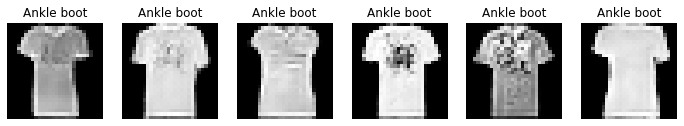

In [44]:
target_generate(9)